In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve

LAMBDA = 1.73e-9 # Decay constant for tritium
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.1

class Component:
    def __init__(self, name, residence_time, initial_inventory=0, tritium_source=0):
        self.name = name
        self.residence_time = residence_time
        self.input_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.output_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.tritium_inventory = initial_inventory
        self.tritium_source = tritium_source
        # self.equation = 0

    def add_input_port(self, port_name, incoming_fraction=1.0):
        if not (0 <= incoming_fraction <= 1):
            raise ValueError("Incoming fraction must be between 0 and 1")
        port = Port(port_name)
        port.incoming_fraction = incoming_fraction
        self.input_ports[port_name] = port
        return port

    def add_output_port(self, port_name):
        port = Port(port_name)
        self.output_ports[port_name] = port
        return port

    def __str__(self):
        return f"{self.name}: Residence Time = {self.residence_time}, Tritium Inventory = {self.tritium_inventory}"

    def add_tritium(self, amount):
        self.tritium_inventory += amount

    def remove_tritium(self, amount):
        if self.tritium_inventory >= amount:
            self.tritium_inventory -= amount
            return amount
        else:
            removed_amount = self.tritium_inventory
            self.tritium_inventory = 0
            return removed_amount
        
    def get_inflow(self):
        inflow = 0
        for port in self.input_ports.values():
            inflow += port.flow_rate
        return inflow   
        
    def get_outflow(self):
        return self.tritium_inventory / self.residence_time
    
    def calculate_inventory_derivative(self):
        inflow = self.get_inflow()
        outflow = self.get_outflow()
        decay = self.tritium_inventory * LAMBDA  # assuming decay_rate is a constant
        dydt = inflow - outflow - decay + self.tritium_source
        return dydt
    
    def update_inventory(self, new_value):
        self.tritium_inventory = new_value
    
class Plasma(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # From fueling system
    def get_inflow(self):
        return self.N_burn / self.TBE

    # Exhaust
    def get_outflow(self):
        return (1 - self.TBE)/self.TBE * self.N_burn
    
    def calculate_inventory_derivative(self):
        return super().calculate_inventory_derivative() - self.N_burn


class FuelingSystem(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # To plasma
    def get_outflow(self):
        return self.N_burn/self.TBE

class Port:
    def __init__(self, name, incoming_fraction=1.0):
        self.name = name
        self.flow_rate = 0
        self.incoming_fraction = incoming_fraction
        
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
    
class ComponentMap:
    def __init__(self):
        self.components = {}
        self.connections = {}

    def add_component(self, component):
        self.components[component.name] = component

    def connect_ports(self, component1, port1, component2, port2):
        if component1.name not in self.connections:
            self.connections[component1.name] = {}
        if component2.name not in self.connections:
            self.connections[component2.name] = {}

        self.connections[component1.name][port1.name] = (component2.name, port2.name)
        self.connections[component2.name][port2.name] = (component1.name, port1.name)
        if port1 and port2:
                port1.set_flow_rate(component1.get_outflow())
                port2.set_flow_rate(component1.get_outflow() * port2.incoming_fraction)

    def disconnect_ports(self, component1, port1, component2, port2):
        if component1.name in self.connections and port1.name in self.connections[component1.name]:
            del self.connections[component1.name][port1.name]
        if component2.name in self.connections and port2.name in self.connections[component2.name]:
            del self.connections[component2.name][port2.name]

    def get_connected_ports(self, component, port):
        if component.name in self.connections and port.name in self.connections[component.name]:
            connected_component_name, connected_port_name = self.connections[component.name][port.name]
            connected_component = self.components[connected_component_name]
            connected_port = connected_component.input_ports[connected_port_name]
            return connected_component, connected_port
        else:
            return None, None
        
    def update_flow_rates(self):
        for component_name, ports in self.connections.items():
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                if port_name in self.components[component_name].output_ports:
                    component = self.components[component_name]
                    port = component.output_ports[port_name]
                    connected_component = self.components[connected_component_name]
                    connected_port = connected_component.input_ports[connected_port_name]
                    port.set_flow_rate(component.get_outflow())
                    connected_port.set_flow_rate(component.get_outflow() * connected_port.incoming_fraction)

    def print_connected_map(self):
        for component_name, ports in self.connections.items():
            print(f"Component: {component_name}")
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                print(f"  Port: {port_name} -> Connected Component: {connected_component_name}, Connected Port: {connected_port_name}")

class Simulate:
    def __init__(self, dt, final_time, component_map):
        self.dt = dt
        self.final_time = final_time
        self.time = []
        self.n_steps = int(final_time / dt)
        self.initial_conditions = {name: component.tritium_inventory for name, component in component_map.components.items()}
        self.I_startup = component_map.components['Fueling System'].tritium_inventory
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        self.components = component_map.components
        self.component_map = component_map

    def run(self):
        while True:
            self.y[0] = [component.tritium_inventory for component in self.components.values()] # self.initial_conditions, possibly updated by the restart method
            t,y = self.forward_euler()
            if self.components['Fueling System'].tritium_inventory < 0:
                print("Error: Tritium inventory in Fueling System is below zero.")
                self.update_I_startup()
                self.restart()
            else:
                return t,y
            
    def update_I_startup(self):
        self.I_startup += 0.1
        self.initial_conditions['Fueling System'] = self.I_startup

    def restart(self):
        self.time = []
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        for component, initial_condition in zip(self.components.values(), self.initial_conditions.values()):
            component.tritium_inventory = initial_condition

    def forward_euler(self):
        print(self.y[0])
        for n in range(self.n_steps):
            t = n * self.dt
            if n % 1000 == 0:
                print(f"Percentage completed = {n/self.n_steps * 100:.1f}%", end='\r')
            dydt = self.f(self.y[n])
            self.y[n+1] = self.y[n] + self.dt * dydt
            self.time.append(t)
            for i, component in enumerate(self.components.values()):
                component.update_inventory(self.y[n+1][i])
            self.component_map.update_flow_rates()
        return [self.time, self.y[:-1,:]]

    def f(self, y):
        dydt = np.zeros_like(y)
        for i, component in enumerate(self.components.values()):
            dydt[i] += component.calculate_inventory_derivative()
        return dydt 
    
    

In [14]:
def visualize_connections(component_map):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for each component
    for component in component_map.components.values():
        G.add_node(component.name)

    # Add edges for each connection
    for component_name, ports in component_map.connections.items():
        for port_name, (connected_component_name, _) in ports.items():
            if port_name in component_map.components[component_name].output_ports:
                G.add_edge(component_name, connected_component_name)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray', arrows=True)

    # Show the plot
    plt.show()


In [15]:
tau_ofc = 2 * 3600
tau_ifc = 4 * 3600
I_startup = 0.5 
TBE = 0.02
component1 = FuelingSystem("Fueling System", N_burn, TBE, initial_inventory=I_startup)
component2 = Component("OFC", tau_ofc, initial_inventory=0, tritium_source=N_burn * TBR)
component3 = Component("IFC", tau_ifc)
component4 = Plasma("Plasma", N_burn, TBE)
port1 = component1.add_output_port("Port 1")
port2 = component4.add_input_port("Port 2")
port3 = component4.add_output_port("Port 3")
port4 = component3.add_input_port("Port 4")
port5 = component3.add_output_port("Port 5")
port6 = component2.add_output_port("Port 6")
port7 = component1.add_input_port("Port 7")
port8 = component3.add_input_port("Port 8")

component_map = ComponentMap()
component_map.add_component(component1)
component_map.add_component(component2)
component_map.add_component(component3)
component_map.add_component(component4)
component_map.connect_ports(component1, port1, component4, port2)
component_map.connect_ports(component4, port3, component3, port4)
component_map.connect_ports(component3, port5, component1, port7)
component_map.connect_ports(component2, port6, component3, port8)
component_map.print_connected_map()
# visualize_connections(component_map)
component1.get_inflow()

Component: Fueling System
  Port: Port 1 -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 7 -> Connected Component: IFC, Connected Port: Port 5
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Port 1
  Port: Port 3 -> Connected Component: IFC, Connected Port: Port 4
Component: IFC
  Port: Port 4 -> Connected Component: Plasma, Connected Port: Port 3
  Port: Port 5 -> Connected Component: Fueling System, Connected Port: Port 7
  Port: Port 8 -> Connected Component: OFC, Connected Port: Port 6
Component: OFC
  Port: Port 6 -> Connected Component: IFC, Connected Port: Port 8


0.0

[0.5 0.  0.  0. ]
[ 7.35138258e-01  7.36550826e-03  6.70922302e-01 -4.23516469e-15]


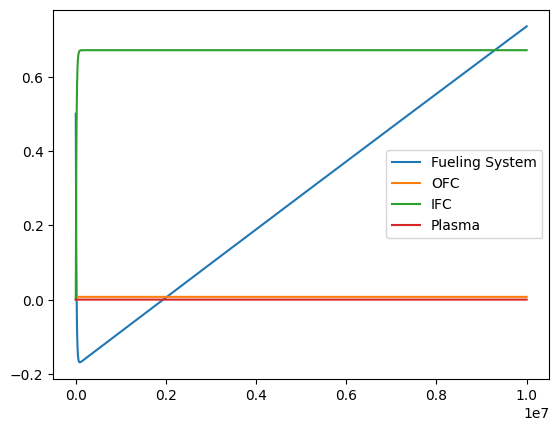

In [16]:
simulation = Simulate(0.1, 1e7, component_map)
t, y = simulation.run()
plt.plot(t, y)
plt.legend(component_map.components.keys())
print(y[-1,:])

Component: Fueling System
  Port: Fueling to Plasma -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 31 -> Connected Component: VP, Connected Port: VP to Fueling System
  Port: Port 12 -> Connected Component: Membrane, Connected Port: Membrane to fueling system
  Port: Port 7 -> Connected Component: ISS, Connected Port: ISS to fueling system
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Fueling to Plasma
  Port: Plasma to VP -> Connected Component: VP, Connected Port: Port 28
Component: VP
  Port: Port 28 -> Connected Component: Plasma, Connected Port: Plasma to VP
  Port: VP to fuel_cleanup -> Connected Component: Fuel cleanup, Connected Port: Port 4
  Port: VP to Fueling System -> Connected Component: Fueling System, Connected Port: Port 31
Component: Fuel cleanup
  Port: Port 4 -> Connected Component: VP, Connected Port: VP to fuel_cleanup
  Port: fuel_cleanup to ISS -> Connected Component: ISS, Connected Port: Port 32
Co

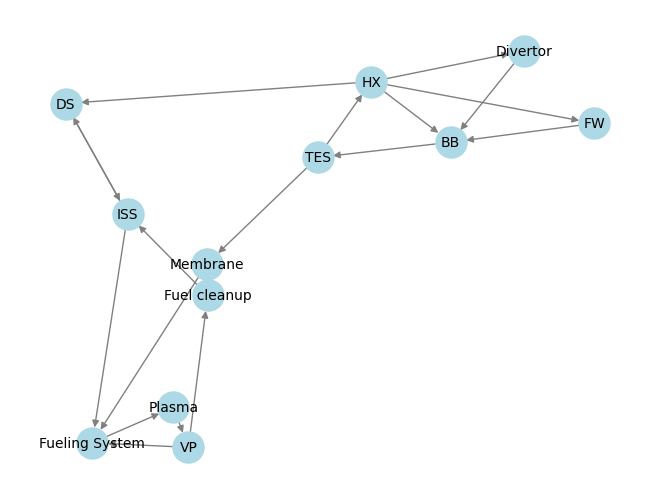

Startup inventory is: 1.1
Initial inventories = [1.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.1 kg067.49624648, Error = 1.4477308241112041e-13, dt = 50, dt_new = 345368069.58362726
Doubling time: 1.558885638516187 

Startup inventory is: 1.1 

Error: Tritium inventory in Fueling System is below zero. Difference is -0.5468196687891475 kg
Updated I_startup to 1.6468196687891474
Initial inventories = [1.6468196687891474, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.6468196687891474 kgrror = 1.4077627952246985e-13, dt = 50, dt_new = 355173472.19010226 = 699.0242012986591
Doubling time: nan 

Startup inventory is: 1.6468196687891474 

Updated TBR at 1.061. Production is now 9.8673e-07
Initial inventories = [1.6468196687891474, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.6468196687891474 kgrror = 1.4477308241112041e-13, dt = 50, dt_new = 345368069.583627265 699.0241943463858
Doubling time: 2.073137604894199 

Startup inventory is: 1.6468196687891474 

Updated TBR at 1.0619999999999998. Pr

/Users/meschini/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


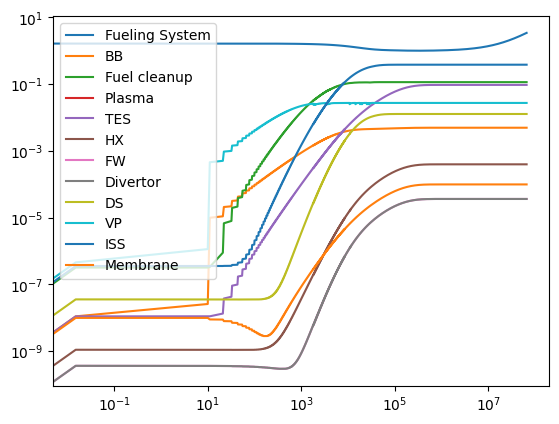

Component inventories [ 3.43798390e+00  4.94207112e-03  1.14812602e-01 -2.80474591e-14
  9.48640996e-02  3.95225098e-04  3.62252821e-05  3.62252821e-05
  1.27538123e-02  2.73392377e-02  3.82653828e-01  9.88068726e-05]


In [1]:

from fuelingSystem import FuelingSystem
from component import Component
from plasma import Plasma
from breedingBlanket import BreedingBlanket
from componentMap import ComponentMap
from matplotlib import pyplot as plt
from simulate import Simulate
from tools.utils import visualize_connections
import numpy as np


# TODO: pulsed source and fp 

LAMBDA = 1.73e-9 # Decay constant for tritium
AF = 0.99
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.06
tau_bb = 1.25 * 3600
tau_fc =  3600
tau_tes = 24 * 3600
tau_HX = 1 * 3600
tau_FW = 1000
tau_div = 1000
tau_ds = 3600
tau_vp = 600
tau_iss = 3 * 3600
tau_membrane = 100
pulse_period = 1800

f_dir = 0.3
f_iss_ds = 0.1

I_startup = 1.1
TBE = 0.02
tes_efficiency = 0.9
final_time = 2.1 * 3600 * 24 * 365 # NB: longer than doubling time
hx_to_fw = 0.33
hx_to_div = 0.33
hx_to_ds = 1e-4
hx_to_BB = 1 - hx_to_fw - hx_to_div - hx_to_ds

q = 0.25
t_res = 24 * 3600
I_reserve = N_burn / TBE * q * t_res


# Define components
fueling_system = FuelingSystem("Fueling System", N_burn, TBE, AF, pulse_period, initial_inventory=I_startup)
BB = BreedingBlanket("BB", tau_bb, initial_inventory=0, N_burn = N_burn, TBR = TBR)
FW = Component("FW", residence_time = tau_FW)
divertor = Component("Divertor", residence_time = tau_div)
fuel_cleanup = Component("Fuel cleanup", tau_fc)
plasma = Plasma("Plasma", N_burn, TBE, AF, pulse_period) 
TES = Component("TES", residence_time = tau_tes)
HX = Component("HX", residence_time = tau_HX)
DS = Component("DS", residence_time = tau_ds)
VP = Component("VP", residence_time = tau_vp)
ISS = Component("ISS", residence_time = tau_iss)
membrane = Component("Membrane", residence_time = tau_membrane)

# Define ports
port1 = fueling_system.add_output_port("Fueling to Plasma")
port2 = plasma.add_input_port("Port 2")
port3 = plasma.add_output_port("Plasma to VP")
port4 = fuel_cleanup.add_input_port("Port 4", incoming_fraction= 1 - f_dir)
port5 = fuel_cleanup.add_output_port("fuel_cleanup to ISS")
port6 = BB.add_output_port("OFC to TES")
port7 = fueling_system.add_input_port("Port 7", incoming_fraction=1 - f_iss_ds)
port8 = fuel_cleanup.add_input_port("Port 8")
port9 = TES.add_output_port("TES to Fueling System")
port10 = TES.add_output_port("TES to HX")
port11 = TES.add_input_port("Port 11")
port12 = fueling_system.add_input_port("Port 12")
port13 = HX.add_input_port("Port 13", incoming_fraction=1-tes_efficiency)
port14 = HX.add_output_port("HX to BB")
port15 = BB.add_input_port("Port 15", incoming_fraction= hx_to_BB)
port16 = FW.add_input_port("Port 16", incoming_fraction=hx_to_fw)
port17 = FW.add_output_port("FW to BB")
port18 = divertor.add_input_port("Port 18", incoming_fraction=hx_to_div)
port19 = divertor.add_output_port("Divertor to FW")
port20 = HX.add_output_port("HX to FW")
port21 = HX.add_output_port("HX to div")
port22 = BB.add_input_port("Port 22")
port23 = BB.add_input_port("Port 23")
port24 = DS.add_input_port("Port 24", incoming_fraction=hx_to_ds)
port25 = DS.add_output_port("DS to fuel cleanup")
port26 = HX.add_output_port("HX to DS")
port27 = fuel_cleanup.add_input_port("Port 27")  
port28 = VP.add_input_port("Port 28")
port29 = VP.add_output_port("VP to fuel_cleanup")
port30 = VP.add_output_port("VP to Fueling System")
port31 = fueling_system.add_input_port("Port 31", incoming_fraction=f_dir)
port32 = ISS.add_input_port("Port 32")
port33 = ISS.add_input_port("Port 33")
port34 = ISS.add_output_port("ISS to fueling system")
port35 = DS.add_input_port("Port 35", incoming_fraction=f_iss_ds)
port36 = ISS.add_output_port("ISS to DS")
port37 = membrane.add_input_port("Port 37", incoming_fraction=tes_efficiency)
port38 = membrane.add_output_port("Membrane to fueling system")

# Add components to component map
component_map = ComponentMap()
component_map.add_component(fueling_system)
component_map.add_component(BB)
component_map.add_component(fuel_cleanup)
component_map.add_component(plasma)
component_map.add_component(TES)
component_map.add_component(HX)
component_map.add_component(FW)
component_map.add_component(divertor)
component_map.add_component(DS)
component_map.add_component(VP)
component_map.add_component(ISS)
component_map.add_component(membrane)

# Connect ports
component_map.connect_ports(fueling_system, port1, plasma, port2)
component_map.connect_ports(plasma, port3, VP, port28)
component_map.connect_ports(VP, port29, fuel_cleanup, port4)
component_map.connect_ports(VP, port30, fueling_system, port31)
component_map.connect_ports(fuel_cleanup, port5, ISS, port32)
component_map.connect_ports(BB, port6, TES, port11)
component_map.connect_ports(TES, port9, membrane, port37)
component_map.connect_ports(membrane, port38, fueling_system, port12)
component_map.connect_ports(TES, port10, HX, port13)
component_map.connect_ports(HX, port14, BB, port15)
component_map.connect_ports(HX, port20, FW, port16)
component_map.connect_ports(HX, port21, divertor, port18)
component_map.connect_ports(FW, port17, BB, port22)
component_map.connect_ports(divertor, port19, BB, port23)
component_map.connect_ports(HX, port26, DS, port24)
component_map.connect_ports(DS, port25, ISS, port33)
component_map.connect_ports(ISS, port34, fueling_system, port7)
component_map.connect_ports(ISS, port36, DS, port35)

component_map.print_connected_map()
visualize_connections(component_map)
print(f'Startup inventory is: {fueling_system.tritium_inventory}')
simulation = Simulate(dt=0.01, final_time=final_time, I_reserve=I_reserve, component_map=component_map)
t, y = simulation.run()
# np.savetxt('tritium_inventory.txt', [t,y], delimiter=',')
fig,ax = plt.subplots()
ax.loglog(t, y)
ax.legend(component_map.components.keys())
plt.show()
print(f"Component inventories {y[-1]}")

In [4]:
# for component in component_map.components.values():
#     print(f'{component.name} inventory: {component.tritium_inventory * 1e3:.3f} g')

for component in component_map.components.values():
# print component flows
    print(f'{component.name} inflow: {component.get_inflow() * 1e6:.3f} g/s')
    print(f'{component.name} outflow: {component.get_outflow() * 1e6:.3f} g/s')



Fueling System inflow: 46.546 g/s
Fueling System outflow: 46.500 g/s
BB inflow: 0.110 g/s
BB outflow: 1.098 g/s
Fuel cleanup inflow: 31.896 g/s
Fuel cleanup outflow: 31.892 g/s
Plasma inflow: 46.500 g/s
Plasma outflow: 45.570 g/s
TES inflow: 1.098 g/s
TES outflow: 1.098 g/s
HX inflow: 0.110 g/s
HX outflow: 0.110 g/s
FW inflow: 0.036 g/s
FW outflow: 0.036 g/s
Divertor inflow: 0.036 g/s
Divertor outflow: 0.036 g/s
DS inflow: 3.543 g/s
DS outflow: 3.543 g/s
VP inflow: 45.570 g/s
VP outflow: 45.565 g/s
ISS inflow: 35.435 g/s
ISS outflow: 35.431 g/s
Membrane inflow: 0.988 g/s
Membrane outflow: 0.988 g/s


/Users/meschini/Library/Python/3.12/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/meschini/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


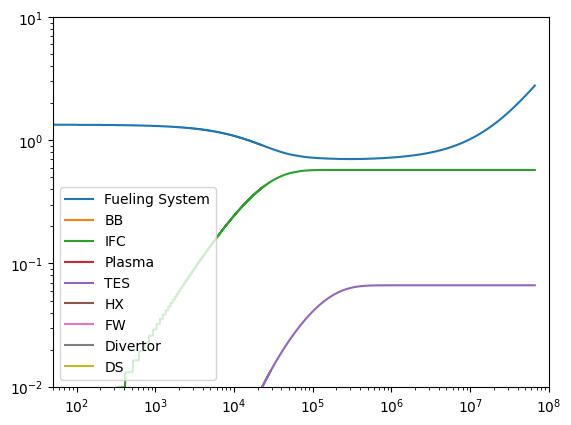

In [24]:
plt.loglog(t, y)
plt.xlim(50, 1e8)
plt.ylim(1e-2, 10)
plt.legend(component_map.components.keys())

In [5]:
# print outflows of each component
for component in component_map.components.values():
    print(f"Outflow of {component.name} = {component.get_outflow()}")

# print inflows of each component
for component in component_map.components.values():
    print(f"Inflow of {component.name} = {component.get_inflow()}")

Outflow of Fueling System = 4.65e-05
Outflow of BB = 1.0982380268874258e-06
Outflow of Fuel cleanup = 3.189238944970508e-05
Outflow of Plasma = 4.557e-05
Outflow of TES = 1.0979641155834444e-06
Outflow of HX = 1.0978474934399058e-07
Outflow of FW = 3.6225282085570265e-08
Outflow of Divertor = 3.6225282085570265e-08
Outflow of DS = 3.5427256428593476e-06
Outflow of VP = 4.55653961635024e-05
Outflow of ISS = 3.54309100104402e-05
Outflow of Membrane = 9.880687262165886e-07
Inflow of Fueling System = 4.654550658466349e-05
Inflow of BB = 1.0976640047316293e-07
Inflow of Fuel cleanup = 3.189577731445168e-05
Inflow of Plasma = 4.65e-05
Inflow of TES = 1.0982380268874258e-06
Inflow of HX = 1.0979641155834442e-07
Inflow of FW = 3.6228967283516895e-08
Inflow of Divertor = 3.6228967283516895e-08
Inflow of DS = 3.5431019795189543e-06
Inflow of VP = 4.557e-05
Inflow of ISS = 3.543511509256443e-05
Inflow of Membrane = 9.881677040251e-07


In [5]:
# Test PulsedSource
import numpy as np

class PulsedSource:
    def __init__(self, amplitude, pulse_duration, pulse_period):
        """
        Initializes a PulsedSource object.

        Parameters:
        amplitude (float): The amplitude of the pulse.
        pulse_duration (float): The duration of each pulse.
        pulse_period (float): The period between pulses.
        """
        self.amplitude = amplitude
        self.pulse_duration = pulse_duration
        self.pulse_period = pulse_period
        self.current_time = 0

    def set_current_time(self, time):
        """
        Sets the current time to zero.
        """
        self.current_time = time

    def get_current_time(self):
        """
        Returns the current time.
        """
        return self.current_time

    def get_pulse(self):
        """
        Returns the value of the pulse at the given time.

        Parameters:
        current_time (float): The current time.

        Returns:
        float: The value of the pulse at the given time.
        """
        pulse_time = self.get_current_time() % self.pulse_period
        if pulse_time < self.pulse_duration:
            return self.amplitude  # Pulse on
        else:
            return 0.0  # Pulse off


pulse_period = 10
pulse_duration = 4
amplitude = 2

pulsed_source = PulsedSource(amplitude, pulse_duration, pulse_period)
t = np.linspace(0, 10, 11)
y = []
for time in t:
    pulsed_source.set_current_time(time)
    # print(pulsed_source.get_current_time())
    print(pulsed_source.get_pulse())
    y.append(pulsed_source.get_pulse())
    

2
2
2
2
0.0
0.0
0.0
0.0
0.0
0.0
2


Component: Fueling System
  Port: Fueling to Plasma -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 31 -> Connected Component: VP, Connected Port: VP to Fueling System
  Port: Port 12 -> Connected Component: Membrane, Connected Port: Membrane to fueling system
  Port: Port 7 -> Connected Component: ISS, Connected Port: ISS to fueling system
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Fueling to Plasma
  Port: Plasma to VP -> Connected Component: VP, Connected Port: Port 28
Component: VP
  Port: Port 28 -> Connected Component: Plasma, Connected Port: Plasma to VP
  Port: VP to fuel_cleanup -> Connected Component: Fuel cleanup, Connected Port: Port 4
  Port: VP to Fueling System -> Connected Component: Fueling System, Connected Port: Port 31
Component: Fuel cleanup
  Port: Port 4 -> Connected Component: VP, Connected Port: VP to fuel_cleanup
  Port: fuel_cleanup to ISS -> Connected Component: ISS, Connected Port: Port 32
Co

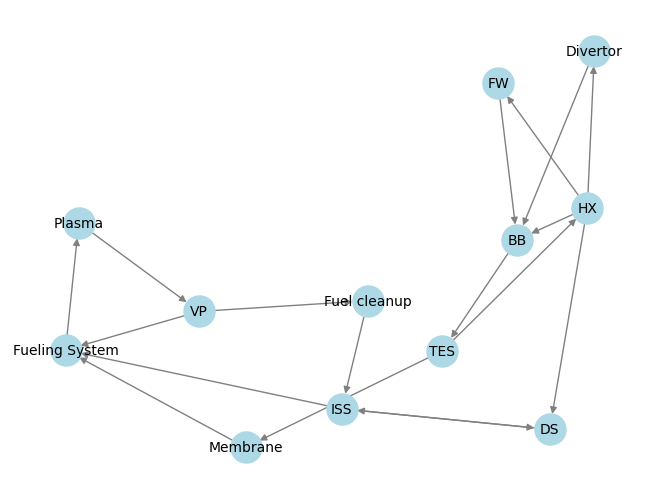

Startup inventory is: 0
Initial inventories = [0, 0.0001, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 0 kg6.30563289239, Error = 6.262104329454989e-07, dt = 21.844993669385776, dt_new = 34.88442945070992
Doubling time: 0.0 

Startup inventory is: 0 



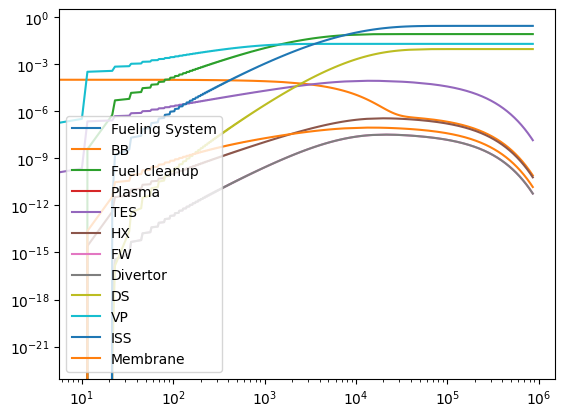

Component inventories [-9.47917426e-01  7.99697526e-11  8.03688214e-02 -2.01217159e-15
  1.40078057e-08  6.06085981e-11  5.61307848e-12  5.61307848e-12
  8.92763788e-03  1.91374664e-02  2.67857587e-01  1.46050565e-11]


In [1]:

from fuelingSystem import FuelingSystem
from component import Component
from plasma import Plasma
from breedingBlanket import BreedingBlanket
from componentMap import ComponentMap
from matplotlib import pyplot as plt
from simulate import Simulate
from tools.utils import visualize_connections
import numpy as np


# TODO: pulsed source and fp 

LAMBDA = 1.73e-9 # Decay constant for tritium
AF = 0.7
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.062
tau_bb = 1.25 * 3600
tau_fc =  3600
tau_tes = 24 * 3600
tau_HX = 1 * 3600
tau_FW = 1000
tau_div = 1000
tau_ds = 3600
tau_vp = 600
tau_iss = 3 * 3600
tau_membrane = 100
pulse_period = 1800

f_dir = 0.3
f_iss_ds = 0.1

I_startup = 1.6
TBE = 0.02
tes_efficiency = 0.9
final_time = 3600 * 24 * 10 # NB: longer than doubling time
hx_to_fw = 0.33
hx_to_div = 0.33
hx_to_ds = 1e-4
hx_to_BB = 1 - hx_to_fw - hx_to_div - hx_to_ds

q = 0.25
t_res = 24 * 3600
I_reserve = N_burn / TBE * q * t_res


# Define components
fueling_system = FuelingSystem("Fueling System", N_burn, TBE, AF=AF, initial_inventory=I_startup)
BB = BreedingBlanket("BB", tau_bb, initial_inventory=0, N_burn = N_burn, TBR = TBR, AF=AF)
FW = Component("FW", residence_time = tau_FW)
divertor = Component("Divertor", residence_time = tau_div)
fuel_cleanup = Component("Fuel cleanup", tau_fc)
plasma = Plasma("Plasma", N_burn, TBE, AF=AF) 
TES = Component("TES", residence_time = tau_tes)
HX = Component("HX", residence_time = tau_HX)
DS = Component("DS", residence_time = tau_ds)
VP = Component("VP", residence_time = tau_vp)
ISS = Component("ISS", residence_time = tau_iss)
membrane = Component("Membrane", residence_time = tau_membrane)

# Define ports
port1 = fueling_system.add_output_port("Fueling to Plasma")
port2 = plasma.add_input_port("Port 2")
port3 = plasma.add_output_port("Plasma to VP")
port4 = fuel_cleanup.add_input_port("Port 4", incoming_fraction= 1 - f_dir)
port5 = fuel_cleanup.add_output_port("fuel_cleanup to ISS")
port6 = BB.add_output_port("OFC to TES")
port7 = fueling_system.add_input_port("Port 7", incoming_fraction=1 - f_iss_ds)
port8 = fuel_cleanup.add_input_port("Port 8")
port9 = TES.add_output_port("TES to Fueling System")
port10 = TES.add_output_port("TES to HX")
port11 = TES.add_input_port("Port 11")
port12 = fueling_system.add_input_port("Port 12")
port13 = HX.add_input_port("Port 13", incoming_fraction=1-tes_efficiency)
port14 = HX.add_output_port("HX to BB")
port15 = BB.add_input_port("Port 15", incoming_fraction= hx_to_BB)
port16 = FW.add_input_port("Port 16", incoming_fraction=hx_to_fw)
port17 = FW.add_output_port("FW to BB")
port18 = divertor.add_input_port("Port 18", incoming_fraction=hx_to_div)
port19 = divertor.add_output_port("Divertor to FW")
port20 = HX.add_output_port("HX to FW")
port21 = HX.add_output_port("HX to div")
port22 = BB.add_input_port("Port 22")
port23 = BB.add_input_port("Port 23")
port24 = DS.add_input_port("Port 24", incoming_fraction=hx_to_ds)
port25 = DS.add_output_port("DS to fuel cleanup")
port26 = HX.add_output_port("HX to DS")
port27 = fuel_cleanup.add_input_port("Port 27")  
port28 = VP.add_input_port("Port 28")
port29 = VP.add_output_port("VP to fuel_cleanup")
port30 = VP.add_output_port("VP to Fueling System")
port31 = fueling_system.add_input_port("Port 31", incoming_fraction=f_dir)
port32 = ISS.add_input_port("Port 32")
port33 = ISS.add_input_port("Port 33")
port34 = ISS.add_output_port("ISS to fueling system")
port35 = DS.add_input_port("Port 35", incoming_fraction=f_iss_ds)
port36 = ISS.add_output_port("ISS to DS")
port37 = membrane.add_input_port("Port 37", incoming_fraction=tes_efficiency)
port38 = membrane.add_output_port("Membrane to fueling system")

# Add components to component map
component_map = ComponentMap()
component_map.add_component(fueling_system)
component_map.add_component(BB)
component_map.add_component(fuel_cleanup)
component_map.add_component(plasma)
component_map.add_component(TES)
component_map.add_component(HX)
component_map.add_component(FW)
component_map.add_component(divertor)
component_map.add_component(DS)
component_map.add_component(VP)
component_map.add_component(ISS)
component_map.add_component(membrane)

# Connect ports
component_map.connect_ports(fueling_system, port1, plasma, port2)
component_map.connect_ports(plasma, port3, VP, port28)
component_map.connect_ports(VP, port29, fuel_cleanup, port4)
component_map.connect_ports(VP, port30, fueling_system, port31)
component_map.connect_ports(fuel_cleanup, port5, ISS, port32)
component_map.connect_ports(BB, port6, TES, port11)
component_map.connect_ports(TES, port9, membrane, port37)
component_map.connect_ports(membrane, port38, fueling_system, port12)
component_map.connect_ports(TES, port10, HX, port13)
component_map.connect_ports(HX, port14, BB, port15)
component_map.connect_ports(HX, port20, FW, port16)
component_map.connect_ports(HX, port21, divertor, port18)
component_map.connect_ports(FW, port17, BB, port22)
component_map.connect_ports(divertor, port19, BB, port23)
component_map.connect_ports(HX, port26, DS, port24)
component_map.connect_ports(DS, port25, ISS, port33)
component_map.connect_ports(ISS, port34, fueling_system, port7)
component_map.connect_ports(ISS, port36, DS, port35)

component_map.print_connected_map()
visualize_connections(component_map)
print(f'Startup inventory is: {fueling_system.tritium_inventory}')
simulation = Simulate(dt=0.01, final_time=final_time, I_reserve=I_reserve, component_map=component_map)
t, y = simulation.run()
# np.savetxt('tritium_inventory.txt', [t,y], delimiter=',')
fig,ax = plt.subplots()
ax.loglog(t, y)
ax.legend(component_map.components.keys())
plt.show()
print(f"Component inventories {y[-1]}")

In [3]:
plt.plot(t[::100], plasma.inflow[::100], 'ro', label='Inflow')
# plt.plot(t[::100], plasma.outflow[::100], 'bo', label='Outflow')
plt.ylabel('Flow')
plt.legend()
plt.show()


NameError: name 't' is not defined

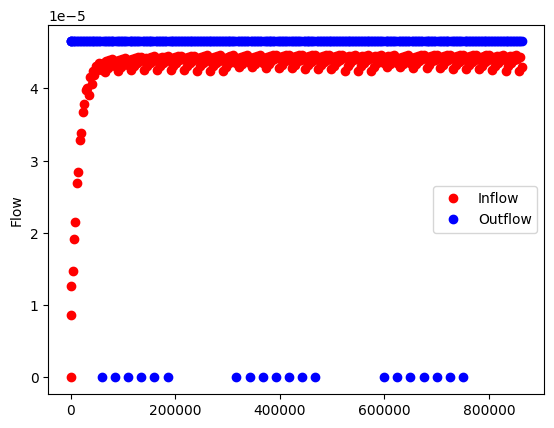

In [16]:
plt.plot(t[::100], fueling_system.inflow[::100], 'ro', label='Inflow')
plt.plot(t[::100], fueling_system.outflow[::100], 'bo', label='Outflow')
plt.ylabel('Flow')
plt.legend()
plt.show()


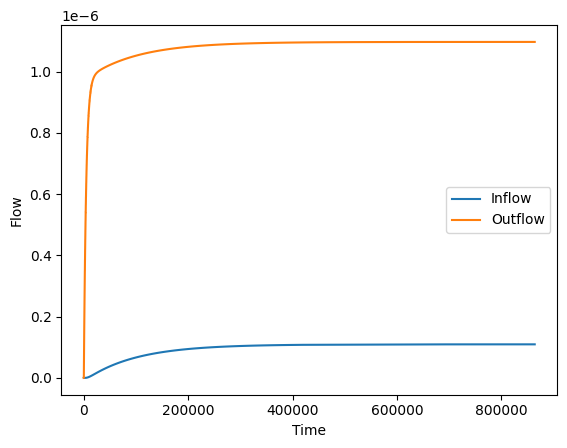

In [18]:
plt.plot(t, BB.inflow, label='Inflow')
plt.plot(t, BB.outflow, label='Outflow')
plt.xlabel('Time')
plt.ylabel('Flow')
plt.legend()
plt.show()


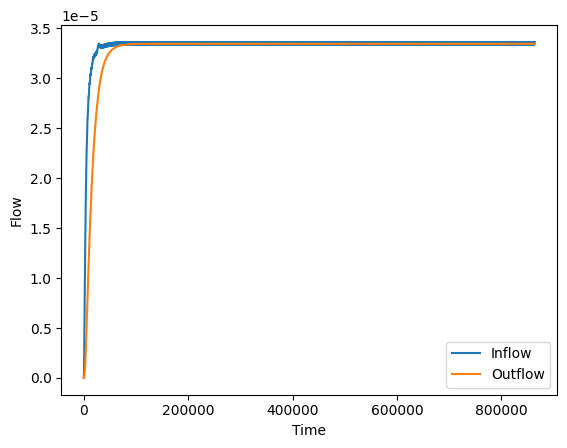

In [19]:
# Plot inflow and outflow of ISS
plt.plot(t, ISS.inflow, label='Inflow')
plt.plot(t, ISS.outflow, label='Outflow')
plt.xlabel('Time')
plt.ylabel('Flow')
plt.legend()
plt.show()


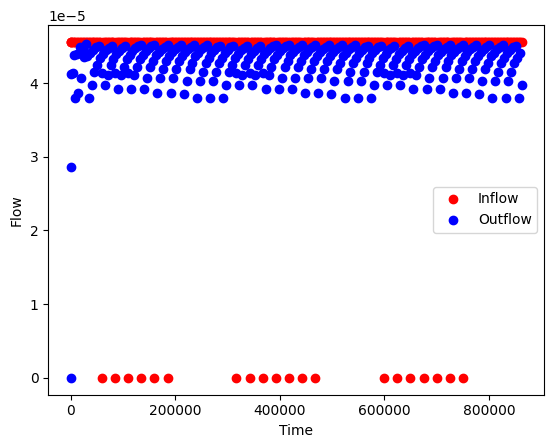

In [21]:
plt.plot(t[::100], VP.inflow[::100], 'ro', label='Inflow')
plt.plot(t[::100], VP.outflow[::100], 'bo', label='Outflow')
plt.xlabel('Time')
plt.ylabel('Flow')
plt.legend()
plt.show()


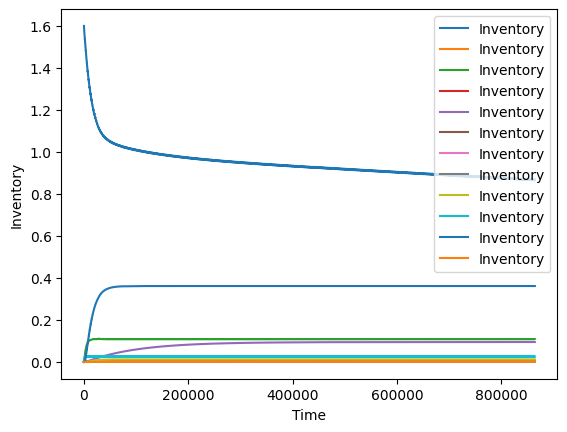

In [24]:
plt.plot(t, y , label='Inventory')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.legend()
plt.show()
